In [74]:
import numpy as np
from data import load_data
from evaluate import qwk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [75]:
# Load Data
X_train, y_train, X_test, y_test, X_predict = load_data()

# PCA Decomposition
pca = PCA(svd_solver='full')
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.transform(X_test)

# Select K Best
kb = SelectKBest()
kbX_train = kb.fit_transform(X_train, y_train)
kbX_test = kb.transform(X_test)

# Variance Threshold
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
vtX_train = vt.fit_transform(X_train, y_train)
vtX_test = vt.transform(X_test)

print(f'Training = {X_train.shape}')
print(f'Testing = {X_test.shape}')

Training = (10495, 361)
Testing = (4498, 361)


---------- KNN Classifier ----------


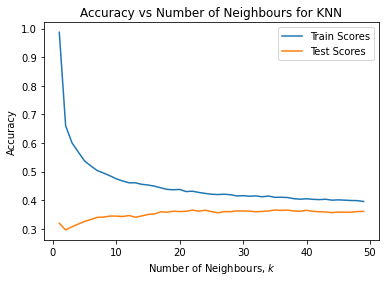

In [76]:
# KNN Classifier
print('---------- KNN Classifier ----------')

dataLabels = ['No Selection', 'PCA', 'K Best', 'Variance Threshold']
data = [(X_train, X_test), (pcaX_train, pcaX_test), (kbX_train, kbX_test), (vtX_train, vtX_test)]
kk = range(1, 50)

for i, label in enumerate(dataLabels):
    xtrain, xtest = data[i]
    
    trainScores = []
    testScores = []
    for k in kk:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(xtrain, y_train)
        trainScores.append(knn.score(xtrain, y_train))
        testScores.append(knn.score(xtest, y_test))

    plt.plot(kk, trainScores, label='Train Scores')
    plt.plot(kk, testScores, label='Test Scores')
    plt.title(f'Accuracy vs Number of Neighbours for KNN with {label}')
    plt.xlabel('Number of Neighbours, $k$')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()
    
    
# print(f'Train Accuracy: {knn.score(X_train, y_train)}')
# print(f'Testing Accuracy: {knn.score(X_test, y_test)}')
# y_pred = knn.predict(X_test)
# print(qwk(y_test, y_pred))
# print(classification_report(y_test, y_pred))

